In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import datetime as datetime
from tqdm import tqdm
import itertools
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from CreateFeatures import CreateFeatures
from GraphSAGE import SiameseGNN_GraphSAGE
from graph_isomorphism import SiameseGNN_GIN
from GAT import SiameseGNN_GAT

In [2]:
feats = "gdp-mis"
with open('../../sGNN_pickle_files/gdp_mis/train_data_gdp_mis.pkl', 'rb') as f:
    train_data = pkl.load(f)

with open('../../sGNN_pickle_files/gdp_mis/val_data_gdp_mis.pkl', 'rb') as f:
    graph_pairs_val = pkl.load(f)
    
with open('../../sGNN_pickle_files/gdp_mis/test_data_gdp_mis.pkl', 'rb') as f:
    graph_pairs_test = pkl.load(f)

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import f1_score, fbeta_score
import numpy as np

def run_model_normal(model, type, lr, training_data_pairs, val_data_pairs, num_epochs=10):
    
    val_acc = 0
    val_f1 = 0
    val_f2 = 0
    val_f05 = 0

    val_loss_arr = []
    train_loss_arr = []
        
    torch.manual_seed(42)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.BCELoss() 

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_losses = []
        for (graph1, graph2, labels) in training_data_pairs:
            optimizer.zero_grad()
            out = model(graph1, graph2)

            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        scheduler.step()

        model.eval()
        with torch.no_grad():
            val_losses = []
            val_pred = []
            val_truth = []

            correct = 0
            total = 0
            for (graph1, graph2, labels) in val_data_pairs:
                out = model(graph1, graph2)

                val_loss = criterion(out, labels)
                val_losses.append(val_loss.item())

                predictions = torch.round(out)

                val_pred.extend(predictions.cpu().numpy())
                val_truth.extend(labels.cpu().numpy())

                correct += (predictions == labels).sum().item()
                total += labels.size(0)

            val_loss = sum(val_losses) / len(val_losses)
            val_accuracy = correct / total

        val_f1 = f1_score(val_truth, val_pred)
        val_f2 = fbeta_score(y_true=val_truth, y_pred=val_pred, beta=2)
        val_f05 = fbeta_score(y_true=val_truth, y_pred=val_pred, beta=1 / 2)

        train_loss_arr.append(sum(train_losses) / len(train_losses))
        val_loss_arr.append(val_loss)
        print(f'Epoch: {epoch + 1}, Training Loss: {sum(train_losses) / len(train_losses)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, F1 Score: {val_f1}, F2 Score: {val_f2}, F0.5 Score: {val_f05}')

    model_name = f"models/real_data/{type}-{feats}.pt"
    torch.save(model.state_dict(), model_name)

    return train_losses, val_losses

In [4]:
input_dim = train_data[0][0].x.shape[1]

# Define hyperparameter grids
learning_rates = [1e-4]
dropout_rates = [0.1]
sort_k_values = [50]
hidden_units_values = [16]

# Create combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, dropout_rates, sort_k_values, hidden_units_values))

for lr, dropout_rate, sort_k, hidden_units in hyperparameter_combinations:
    hyperparameters = f"{lr}_{dropout_rate}_{sort_k}_{hidden_units}"
    model = SiameseGNN_GIN(sort_k, input_dim, dropout = dropout_rate, nhidden=hidden_units)
    fold_scores = run_model_normal(model, "gin", lr, train_data, graph_pairs_val)

 10%|█         | 1/10 [00:10<01:31, 10.12s/it]

Epoch: 1, Training Loss: 0.7041573859140521, Validation Loss: 0.6772207044064998, Validation Accuracy: 0.721875, F1 Score: 0.8348794063079777, F2 Score: 0.8707430340557275, F0.5 Score: 0.8018531717747683


 20%|██        | 2/10 [00:20<01:20, 10.04s/it]

Epoch: 2, Training Loss: 0.6948035275716273, Validation Loss: 0.6894011793658137, Validation Accuracy: 0.634375, F1 Score: 0.7515923566878981, F2 Score: 0.7230392156862745, F0.5 Score: 0.7824933687002652


 30%|███       | 3/10 [00:29<01:09,  9.86s/it]

Epoch: 3, Training Loss: 0.6947493485373551, Validation Loss: 0.6992928631603718, Validation Accuracy: 0.50625, F1 Score: 0.616504854368932, F2 Score: 0.5450643776824035, F0.5 Score: 0.7094972067039106


 40%|████      | 4/10 [00:39<00:58,  9.75s/it]

Epoch: 4, Training Loss: 0.69504735118053, Validation Loss: 0.7010841416195035, Validation Accuracy: 0.45625, F1 Score: 0.5492227979274611, F2 Score: 0.46532045654082527, F0.5 Score: 0.6700379266750948


 50%|█████     | 5/10 [00:49<00:49,  9.81s/it]

Epoch: 5, Training Loss: 0.6917976799110571, Validation Loss: 0.6941080743446946, Validation Accuracy: 0.5, F1 Score: 0.6039603960396039, F2 Score: 0.5272255834053586, F0.5 Score: 0.7068366164542295


 60%|██████    | 6/10 [00:58<00:38,  9.70s/it]

Epoch: 6, Training Loss: 0.686383120267769, Validation Loss: 0.687628997862339, Validation Accuracy: 0.5625, F1 Score: 0.6774193548387096, F2 Score: 0.6192080876158382, F0.5 Score: 0.7477110885045778


 70%|███████   | 7/10 [01:08<00:29,  9.70s/it]

Epoch: 7, Training Loss: 0.6900822874260405, Validation Loss: 0.700604198873043, Validation Accuracy: 0.53125, F1 Score: 0.6376811594202898, F2 Score: 0.5655526992287918, F0.5 Score: 0.7308970099667774


 80%|████████  | 8/10 [01:18<00:19,  9.80s/it]

Epoch: 8, Training Loss: 0.6900916015881984, Validation Loss: 0.6893365886062384, Validation Accuracy: 0.553125, F1 Score: 0.6651053864168618, F2 Score: 0.6016949152542372, F0.5 Score: 0.743455497382199


 90%|█████████ | 9/10 [01:28<00:09,  9.82s/it]

Epoch: 9, Training Loss: 0.6862040492273419, Validation Loss: 0.6983177141286433, Validation Accuracy: 0.53125, F1 Score: 0.6428571428571429, F2 Score: 0.5754475703324808, F0.5 Score: 0.7281553398058253


100%|██████████| 10/10 [01:37<00:00,  9.78s/it]

Epoch: 10, Training Loss: 0.6808161943784503, Validation Loss: 0.6954897604882717, Validation Accuracy: 0.56875, F1 Score: 0.6805555555555556, F2 Score: 0.620253164556962, F0.5 Score: 0.7538461538461538


## Testing Model

In [6]:
def load_model(model_path: str):

    model = SiameseGNN_GIN(50, 27, dropout = 0.05, nhidden=16)
    model.load_state_dict(torch.load(model_path))

    return model

In [7]:
model = load_model('models/real_data/gin-gdp-mis.pt')
model.eval()

SiameseGNN_GIN(
  (gnn): GIN(
    (mlp1): Sequential(
      (0): Linear(in_features=27, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
    (mlp2): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
    (conv1): GINConv(nn=Sequential(
      (0): Linear(in_features=27, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    ))
    (conv2): GINConv(nn=Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=16, bias=True)
    ))
    (linear): Linear(in_features=16, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (similarity): PairwiseDistance()
  (fc1): Linear(in_features=50, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwis

Accuracy: 0.5862068965517241, F1 Score: 0.7027027027027027, F2 Score: 0.6326034063260341, F0.5 Score: 0.790273556231003


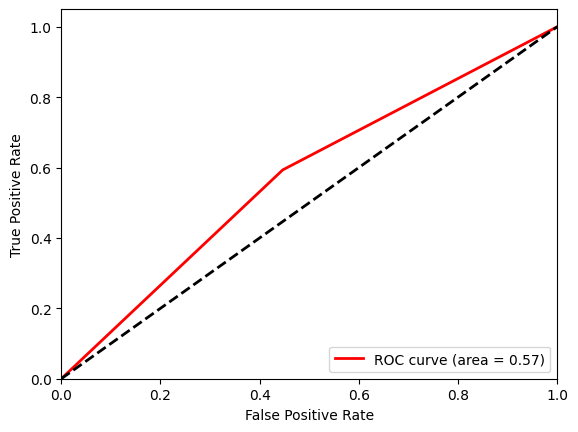

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for (graph1, graph2, label) in graph_pairs_test:
        output = model(graph1, graph2)
        predictions = torch.round(output)
        y_true.append(label.numpy())
        y_pred.append(predictions.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

acc = np.mean(y_true == y_pred)
val_f1 = f1_score(y_true, y_pred)
val_f2 = fbeta_score(y_true, y_pred, beta=2)
val_f05 = fbeta_score(y_true, y_pred, beta=1 / 2)

print(f'Accuracy: {acc}, F1 Score: {val_f1}, F2 Score: {val_f2}, F0.5 Score: {val_f05}')

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()